[![Open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1K72PBcrekap-IKuDJ0KztYB20N7uJQZH#scrollTo=zVcmmoBmIH5h)

In [ ]:
!pip install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.0 MB 15 kB/s 
     |████████████████████████████████| 1.7 MB 49.9 MB/s 
     |████████████████████████████████| 438 kB 67.7 MB/s 
     |████████████████████████████████| 5.9 MB 54.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5

In [ ]:
!nvidia-smi

Sat Sep 10 11:47:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

File func.py

In [ ]:
from __future__ import division
import torch
import math
import random
from PIL import Image, ImageOps, ImageEnhance
try:
    import accimage
except ImportError:
    accimage = None
import numpy as np
import numbers
import types
import collections
import warnings


def _is_pil_image(img):
    if accimage is not None:
        return isinstance(img, (Image.Image, accimage.Image))
    else:
        return isinstance(img, Image.Image)


def _is_tensor_image(img):
    return torch.is_tensor(img) and img.ndimension() == 3


def _is_numpy_image(img):
    return isinstance(img, np.ndarray) and (img.ndim in {2, 3})


def to_tensor(pic):
    """Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
    See ``ToTensor`` for more details.
    Args:
        pic (PIL Image or numpy.ndarray): Image to be converted to tensor.
    Returns:
        Tensor: Converted image.
    """
    if not(_is_pil_image(pic) or _is_numpy_image(pic)):
        raise TypeError('pic should be PIL Image or ndarray. Got {}'.format(type(pic)))

    if isinstance(pic, np.ndarray):
        # handle numpy array
        img = torch.from_numpy(pic.transpose((2, 0, 1)))
        # backward compatibility
        return img.float().div(255)

    if accimage is not None and isinstance(pic, accimage.Image):
        nppic = np.zeros([pic.channels, pic.height, pic.width], dtype=np.float32)
        pic.copyto(nppic)
        return torch.from_numpy(nppic)

    # handle PIL Image
    if pic.mode == 'I':
        img = torch.from_numpy(np.array(pic, np.int32, copy=False))
    elif pic.mode == 'I;16':
        img = torch.from_numpy(np.array(pic, np.int16, copy=False))
    else:
        img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
    # PIL image mode: 1, L, P, I, F, RGB, YCbCr, RGBA, CMYK
    if pic.mode == 'YCbCr':
        nchannel = 3
    elif pic.mode == 'I;16':
        nchannel = 1
    else:
        nchannel = len(pic.mode)
    img = img.view(pic.size[1], pic.size[0], nchannel)
    # put it from HWC to CHW format
    # yikes, this transpose takes 80% of the loading time/CPU
    img = img.transpose(0, 1).transpose(0, 2).contiguous()
    if isinstance(img, torch.ByteTensor):
        return img.float().div(255)
    else:
        return img


def to_pil_image(pic, mode=None):
    """Convert a tensor or an ndarray to PIL Image.
    See :class:`~torchvision.transforms.ToPIlImage` for more details.
    Args:
        pic (Tensor or numpy.ndarray): Image to be converted to PIL Image.
        mode (`PIL.Image mode`_): color space and pixel depth of input data (optional).
    .. _PIL.Image mode: http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#modes
    Returns:
        PIL Image: Image converted to PIL Image.
    """
    if not(_is_numpy_image(pic) or _is_tensor_image(pic)):
        raise TypeError('pic should be Tensor or ndarray. Got {}.'.format(type(pic)))

    npimg = pic
    if isinstance(pic, torch.FloatTensor):
        pic = pic.mul(255).byte()
    if torch.is_tensor(pic):
        npimg = np.transpose(pic.numpy(), (1, 2, 0))

    if not isinstance(npimg, np.ndarray):
        raise TypeError('Input pic must be a torch.Tensor or NumPy ndarray, ' +
                        'not {}'.format(type(npimg)))

    if npimg.shape[2] == 1:
        expected_mode = None
        npimg = npimg[:, :, 0]
        if npimg.dtype == np.uint8:
            expected_mode = 'L'
        if npimg.dtype == np.int16:
            expected_mode = 'I;16'
        if npimg.dtype == np.int32:
            expected_mode = 'I'
        elif npimg.dtype == np.float32:
            expected_mode = 'F'
        if mode is not None and mode != expected_mode:
            raise ValueError("Incorrect mode ({}) supplied for input type {}. Should be {}"
                             .format(mode, np.dtype, expected_mode))
        mode = expected_mode

    elif npimg.shape[2] == 4:
        permitted_4_channel_modes = ['RGBA', 'CMYK']
        if mode is not None and mode not in permitted_4_channel_modes:
            raise ValueError("Only modes {} are supported for 4D inputs".format(permitted_4_channel_modes))

        if mode is None and npimg.dtype == np.uint8:
            mode = 'RGBA'
    else:
        permitted_3_channel_modes = ['RGB', 'YCbCr', 'HSV']
        if mode is not None and mode not in permitted_3_channel_modes:
            raise ValueError("Only modes {} are supported for 3D inputs".format(permitted_3_channel_modes))
        if mode is None and npimg.dtype == np.uint8:
            mode = 'RGB'

    if mode is None:
        raise TypeError('Input type {} is not supported'.format(npimg.dtype))

    return Image.fromarray(npimg, mode=mode)


def normalize(tensor, mean, std):
    """Normalize a tensor image with mean and standard deviation.
    See ``Normalize`` for more details.
    Args:
        tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        mean (sequence): Sequence of means for each channel.
        std (sequence): Sequence of standard deviations for each channely.
    Returns:
        Tensor: Normalized Tensor image.
    """
    if not _is_tensor_image(tensor):
        raise TypeError('tensor is not a torch image.')
    # TODO: make efficient
    for t, m, s in zip(tensor, mean, std):
        t.sub_(m).div_(s)
    return tensor


def resize(img, size, interpolation=Image.BILINEAR):
    """Resize the input PIL Image to the given size.
    Args:
        img (PIL Image): Image to be resized.
        size (sequence or int): Desired output size. If size is a sequence like
            (h, w), the output size will be matched to this. If size is an int,
            the smaller edge of the image will be matched to this number maintaing
            the aspect ratio. i.e, if height > width, then image will be rescaled to
            (size * height / width, size)
        interpolation (int, optional): Desired interpolation. Default is
            ``PIL.Image.BILINEAR``
    Returns:
        PIL Image: Resized image.
    """
    if not _is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))
    if not (isinstance(size, int) or (isinstance(size, collections.Iterable) and len(size) == 2)):
        raise TypeError('Got inappropriate size arg: {}'.format(size))

    if isinstance(size, int):
        w, h = img.size
        if (w <= h and w == size) or (h <= w and h == size):
            return img
        if w < h:
            ow = size
            oh = int(size * h / w)
            return img.resize((ow, oh), interpolation)
        else:
            oh = size
            ow = int(size * w / h)
            return img.resize((ow, oh), interpolation)
    else:
        return img.resize(size[::-1], interpolation)


def scale(*args, **kwargs):
    warnings.warn("The use of the transforms.Scale transform is deprecated, " +
                  "please use transforms.Resize instead.")
    return resize(*args, **kwargs)


def pad(img, padding, fill=0):
    """Pad the given PIL Image on all sides with the given "pad" value.
    Args:
        img (PIL Image): Image to be padded.
        padding (int or tuple): Padding on each border. If a single int is provided this
            is used to pad all borders. If tuple of length 2 is provided this is the padding
            on left/right and top/bottom respectively. If a tuple of length 4 is provided
            this is the padding for the left, top, right and bottom borders
            respectively.
        fill: Pixel fill value. Default is 0. If a tuple of
            length 3, it is used to fill R, G, B channels respectively.
    Returns:
        PIL Image: Padded image.
    """
    if not _is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

    if not isinstance(padding, (numbers.Number, tuple)):
        raise TypeError('Got inappropriate padding arg')
    if not isinstance(fill, (numbers.Number, str, tuple)):
        raise TypeError('Got inappropriate fill arg')

    if isinstance(padding, collections.Sequence) and len(padding) not in [2, 4]:
        raise ValueError("Padding must be an int or a 2, or 4 element tuple, not a " +
                         "{} element tuple".format(len(padding)))

    return ImageOps.expand(img, border=padding, fill=fill)


def crop(img, i, j, h, w):
    """Crop the given PIL Image.
    Args:
        img (PIL Image): Image to be cropped.
        i: Upper pixel coordinate.
        j: Left pixel coordinate.
        h: Height of the cropped image.
        w: Width of the cropped image.
    Returns:
        PIL Image: Cropped image.
    """
    if not _is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

    return img.crop((j, i, j + w, i + h))


def center_crop(img, output_size):
    if isinstance(output_size, numbers.Number):
        output_size = (int(output_size), int(output_size))
    w, h = img.size
    th, tw = output_size
    i = int(round((h - th) / 2.))
    j = int(round((w - tw) / 2.))
    return crop(img, i, j, th, tw)


def resized_crop(img, i, j, h, w, size, interpolation=Image.BILINEAR):
    """Crop the given PIL Image and resize it to desired size.
    Notably used in RandomResizedCrop.
    Args:
        img (PIL Image): Image to be cropped.
        i: Upper pixel coordinate.
        j: Left pixel coordinate.
        h: Height of the cropped image.
        w: Width of the cropped image.
        size (sequence or int): Desired output size. Same semantics as ``scale``.
        interpolation (int, optional): Desired interpolation. Default is
            ``PIL.Image.BILINEAR``.
    Returns:
        PIL Image: Cropped image.
    """
    assert _is_pil_image(img), 'img should be PIL Image'
    img = crop(img, i, j, h, w)
    img = resize(img, size, interpolation)
    return img


def hflip(img):
    """Horizontally flip the given PIL Image.
    Args:
        img (PIL Image): Image to be flipped.
    Returns:
        PIL Image:  Horizontall flipped image.
    """
    if not _is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

    return img.transpose(Image.FLIP_LEFT_RIGHT)


def vflip(img):
    """Vertically flip the given PIL Image.
    Args:
        img (PIL Image): Image to be flipped.
    Returns:
        PIL Image:  Vertically flipped image.
    """
    if not _is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

    return img.transpose(Image.FLIP_TOP_BOTTOM)


def five_crop(img, size):
    """Crop the given PIL Image into four corners and the central crop.
    .. Note::
        This transform returns a tuple of images and there may be a
        mismatch in the number of inputs and targets your ``Dataset`` returns.
    Args:
       size (sequence or int): Desired output size of the crop. If size is an
           int instead of sequence like (h, w), a square crop (size, size) is
           made.
    Returns:
        tuple: tuple (tl, tr, bl, br, center) corresponding top left,
            top right, bottom left, bottom right and center crop.
    """
    if isinstance(size, numbers.Number):
        size = (int(size), int(size))
    else:
        assert len(size) == 2, "Please provide only two dimensions (h, w) for size."

    w, h = img.size
    crop_h, crop_w = size
    if crop_w > w or crop_h > h:
        raise ValueError("Requested crop size {} is bigger than input size {}".format(size,
                                                                                      (h, w)))
    tl = img.crop((0, 0, crop_w, crop_h))
    tr = img.crop((w - crop_w, 0, w, crop_h))
    bl = img.crop((0, h - crop_h, crop_w, h))
    br = img.crop((w - crop_w, h - crop_h, w, h))
    center = center_crop(img, (crop_h, crop_w))
    return (tl, tr, bl, br, center)


def ten_crop(img, size, vertical_flip=False):
    """Crop the given PIL Image into four corners and the central crop plus the
       flipped version of these (horizontal flipping is used by default).
    .. Note::
        This transform returns a tuple of images and there may be a
        mismatch in the number of inputs and targets your ``Dataset`` returns.
       Args:
           size (sequence or int): Desired output size of the crop. If size is an
               int instead of sequence like (h, w), a square crop (size, size) is
               made.
           vertical_flip (bool): Use vertical flipping instead of horizontal
        Returns:
            tuple: tuple (tl, tr, bl, br, center, tl_flip, tr_flip, bl_flip,
                br_flip, center_flip) corresponding top left, top right,
                bottom left, bottom right and center crop and same for the
                flipped image.
    """
    if isinstance(size, numbers.Number):
        size = (int(size), int(size))
    else:
        assert len(size) == 2, "Please provide only two dimensions (h, w) for size."

    first_five = five_crop(img, size)

    if vertical_flip:
        img = vflip(img)
    else:
        img = hflip(img)

    second_five = five_crop(img, size)
    return first_five + second_five


def adjust_brightness(img, brightness_factor):
    """Adjust brightness of an Image.
    Args:
        img (PIL Image): PIL Image to be adjusted.
        brightness_factor (float):  How much to adjust the brightness. Can be
            any non negative number. 0 gives a black image, 1 gives the
            original image while 2 increases the brightness by a factor of 2.
    Returns:
        PIL Image: Brightness adjusted image.
    """
    if not _is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(brightness_factor)
    return img


def adjust_contrast(img, contrast_factor):
    """Adjust contrast of an Image.
    Args:
        img (PIL Image): PIL Image to be adjusted.
        contrast_factor (float): How much to adjust the contrast. Can be any
            non negative number. 0 gives a solid gray image, 1 gives the
            original image while 2 increases the contrast by a factor of 2.
    Returns:
        PIL Image: Contrast adjusted image.
    """
    if not _is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(contrast_factor)
    return img


def adjust_saturation(img, saturation_factor):
    """Adjust color saturation of an image.
    Args:
        img (PIL Image): PIL Image to be adjusted.
        saturation_factor (float):  How much to adjust the saturation. 0 will
            give a black and white image, 1 will give the original image while
            2 will enhance the saturation by a factor of 2.
    Returns:
        PIL Image: Saturation adjusted image.
    """
    if not _is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

    enhancer = ImageEnhance.Color(img)
    img = enhancer.enhance(saturation_factor)
    return img


def adjust_hue(img, hue_factor):
    """Adjust hue of an image.
    The image hue is adjusted by converting the image to HSV and
    cyclically shifting the intensities in the hue channel (H).
    The image is then converted back to original image mode.
    `hue_factor` is the amount of shift in H channel and must be in the
    interval `[-0.5, 0.5]`.
    See https://en.wikipedia.org/wiki/Hue for more details on Hue.
    Args:
        img (PIL Image): PIL Image to be adjusted.
        hue_factor (float):  How much to shift the hue channel. Should be in
            [-0.5, 0.5]. 0.5 and -0.5 give complete reversal of hue channel in
            HSV space in positive and negative direction respectively.
            0 means no shift. Therefore, both -0.5 and 0.5 will give an image
            with complementary colors while 0 gives the original image.
    Returns:
        PIL Image: Hue adjusted image.
    """
    if not(-0.5 <= hue_factor <= 0.5):
        raise ValueError('hue_factor is not in [-0.5, 0.5].'.format(hue_factor))

    if not _is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

    input_mode = img.mode
    if input_mode in {'L', '1', 'I', 'F'}:
        return img

    h, s, v = img.convert('HSV').split()

    np_h = np.array(h, dtype=np.uint8)
    # uint8 addition take cares of rotation across boundaries
    with np.errstate(over='ignore'):
        np_h += np.uint8(hue_factor * 255)
    h = Image.fromarray(np_h, 'L')

    img = Image.merge('HSV', (h, s, v)).convert(input_mode)
    return img


def adjust_gamma(img, gamma, gain=1):
    """Perform gamma correction on an image.
    Also known as Power Law Transform. Intensities in RGB mode are adjusted
    based on the following equation:
        I_out = 255 * gain * ((I_in / 255) ** gamma)
    See https://en.wikipedia.org/wiki/Gamma_correction for more details.
    Args:
        img (PIL Image): PIL Image to be adjusted.
        gamma (float): Non negative real number. gamma larger than 1 make the
            shadows darker, while gamma smaller than 1 make dark regions
            lighter.
        gain (float): The constant multiplier.
    """
    if not _is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

    if gamma < 0:
        raise ValueError('Gamma should be a non-negative real number')

    input_mode = img.mode
    img = img.convert('RGB')

    np_img = np.array(img, dtype=np.float32)
    np_img = 255 * gain * ((np_img / 255) ** gamma)
    np_img = np.uint8(np.clip(np_img, 0, 255))

    img = Image.fromarray(np_img, 'RGB').convert(input_mode)
    return img


def rotate(img, angle, resample=False, expand=False, center=None):
    """Rotate the image by angle and then (optionally) translate it by (n_columns, n_rows)
    Args:
        img (PIL Image): PIL Image to be rotated.
        angle ({float, int}): In degrees degrees counter clockwise order.
        resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter.
            See http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#filters
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
        expand (bool, optional): Optional expansion flag.
            If true, expands the output image to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
        center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.
    """

    if not _is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

    return img.rotate(angle, resample, expand, center)


def to_grayscale(img, num_output_channels=1):
    """Convert image to grayscale version of image.
    Args:
        img (PIL Image): Image to be converted to grayscale.
    Returns:
        PIL Image:  Grayscale version of the image.
                    if num_output_channels == 1 : returned image is single channel
                    if num_output_channels == 3 : returned image is 3 channel with r == g == b
    """
    if not _is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

    if num_output_channels == 1:
        img = img.convert('L')
    elif num_output_channels == 3:
        img = img.convert('L')
        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img, np_img, np_img])
        img = Image.fromarray(np_img, 'RGB')
    else:
        raise ValueError('num_output_channels should be either 1 or 3')

    return img

File transform.py

In [ ]:
from __future__ import division
import torch
import math
import random
from PIL import Image, ImageOps, ImageEnhance
try:
    import accimage
except ImportError:
    accimage = None
import numpy as np
import numbers
import types
import collections
import warnings

__all__ = ["Compose", "ToTensor", "ToPILImage", "Normalize", "Resize", "Scale", "CenterCrop", "Pad",
           "Lambda", "RandomCrop", "RandomHorizontalFlip", "RandomVerticalFlip", "RandomResizedCrop",
           "RandomSizedCrop", "FiveCrop", "TenCrop", "LinearTransformation", "ColorJitter", "RandomRotation",
           "Grayscale", "RandomGrayscale"]


class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img


class ToTensor(object):
    """Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
    Converts a PIL Image or numpy.ndarray (H x W x C) in the range
    [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
    """

    def __call__(self, pic):
        """
        Args:
            pic (PIL Image or numpy.ndarray): Image to be converted to tensor.
        Returns:
            Tensor: Converted image.
        """
        return to_tensor(pic)


class ToPILImage(object):
    """Convert a tensor or an ndarray to PIL Image.
    Converts a torch.*Tensor of shape C x H x W or a numpy ndarray of shape
    H x W x C to a PIL Image while preserving the value range.
    Args:
        mode (`PIL.Image mode`_): color space and pixel depth of input data (optional).
            If ``mode`` is ``None`` (default) there are some assumptions made about the input data:
            1. If the input has 3 channels, the ``mode`` is assumed to be ``RGB``.
            2. If the input has 4 channels, the ``mode`` is assumed to be ``RGBA``.
            3. If the input has 1 channel, the ``mode`` is determined by the data type (i,e,
            ``int``, ``float``, ``short``).
    .. _PIL.Image mode: http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#modes
    """
    def __init__(self, mode=None):
        self.mode = mode

    def __call__(self, pic):
        """
        Args:
            pic (Tensor or numpy.ndarray): Image to be converted to PIL Image.
        Returns:
            PIL Image: Image converted to PIL Image.
        """
        return to_pil_image(pic, self.mode)


class Normalize(object):
    """Normalize an tensor image with mean and standard deviation.
    Given mean: ``(M1,...,Mn)`` and std: ``(S1,..,Sn)`` for ``n`` channels, this transform
    will normalize each channel of the input ``torch.*Tensor`` i.e.
    ``input[channel] = (input[channel] - mean[channel]) / std[channel]``
    Args:
        mean (sequence): Sequence of means for each channel.
        std (sequence): Sequence of standard deviations for each channel.
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized Tensor image.
        """
        return normalize(tensor, self.mean, self.std)


class Resize(object):
    """Resize the input PIL Image to the given size.
    Args:
        size (sequence or int): Desired output size. If size is a sequence like
            (h, w), output size will be matched to this. If size is an int,
            smaller edge of the image will be matched to this number.
            i.e, if height > width, then image will be rescaled to
            (size * height / width, size)
        interpolation (int, optional): Desired interpolation. Default is
            ``PIL.Image.BILINEAR``
    """

    def __init__(self, size, interpolation=Image.BILINEAR):
        assert isinstance(size, int) or (isinstance(size, collections.Iterable) and len(size) == 2)
        self.size = size
        self.interpolation = interpolation

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be scaled.
        Returns:
            PIL Image: Rescaled image.
        """
        return resize(img, self.size, self.interpolation)


class Scale(Resize):
    """
    Note: This transform is deprecated in favor of Resize.
    """
    def __init__(self, *args, **kwargs):
        warnings.warn("The use of the transforms.Scale transform is deprecated, " +
                      "please use transforms.Resize instead.")
        super(Scale, self).__init__(*args, **kwargs)


class CenterCrop(object):
    """Crops the given PIL Image at the center.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
    """

    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be cropped.
        Returns:
            PIL Image: Cropped image.
        """
        return center_crop(img, self.size)


class Pad(object):
    """Pad the given PIL Image on all sides with the given "pad" value.
    Args:
        padding (int or tuple): Padding on each border. If a single int is provided this
            is used to pad all borders. If tuple of length 2 is provided this is the padding
            on left/right and top/bottom respectively. If a tuple of length 4 is provided
            this is the padding for the left, top, right and bottom borders
            respectively.
        fill: Pixel fill value. Default is 0. If a tuple of
            length 3, it is used to fill R, G, B channels respectively.
    """

    def __init__(self, padding, fill=0):
        assert isinstance(padding, (numbers.Number, tuple))
        assert isinstance(fill, (numbers.Number, str, tuple))
        if isinstance(padding, collections.Sequence) and len(padding) not in [2, 4]:
            raise ValueError("Padding must be an int or a 2, or 4 element tuple, not a " +
                             "{} element tuple".format(len(padding)))

        self.padding = padding
        self.fill = fill

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be padded.
        Returns:
            PIL Image: Padded image.
        """
        return pad(img, self.padding, self.fill)


class Lambda(object):
    """Apply a user-defined lambda as a transform.
    Args:
        lambd (function): Lambda/function to be used for transform.
    """

    def __init__(self, lambd):
        assert isinstance(lambd, types.LambdaType)
        self.lambd = lambd

    def __call__(self, img):
        return self.lambd(img)


class RandomCrop(object):
    """Crop the given PIL Image at a random location.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
        padding (int or sequence, optional): Optional padding on each border
            of the image. Default is 0, i.e no padding. If a sequence of length
            4 is provided, it is used to pad left, top, right, bottom borders
            respectively.
    """

    def __init__(self, size, padding=0):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding

    @staticmethod
    def get_params(img, output_size):
        """Get parameters for ``crop`` for a random crop.
        Args:
            img (PIL Image): Image to be cropped.
            output_size (tuple): Expected output size of the crop.
        Returns:
            tuple: params (i, j, h, w) to be passed to ``crop`` for random crop.
        """
        w, h = img.size
        th, tw = output_size
        if w == tw and h == th:
            return 0, 0, h, w

        i = random.randint(0, h - th)
        j = random.randint(0, w - tw)
        return i, j, th, tw

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be cropped.
        Returns:
            PIL Image: Cropped image.
        """
        if self.padding > 0:
            img = pad(img, self.padding)

        i, j, h, w = self.get_params(img, self.size)

        return crop(img, i, j, h, w)


class RandomHorizontalFlip(object):
    """Horizontally flip the given PIL Image randomly with a probability of 0.5."""

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be flipped.
        Returns:
            PIL Image: Randomly flipped image.
        """
        if random.random() < 0.5:
            return hflip(img)
        return img


class RandomVerticalFlip(object):
    """Vertically flip the given PIL Image randomly with a probability of 0.5."""

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be flipped.
        Returns:
            PIL Image: Randomly flipped image.
        """
        if random.random() < 0.5:
            return F.vflip(img)
        return img


class RandomResizedCrop(object):
    """Crop the given PIL Image to random size and aspect ratio.
    A crop of random size (default: of 0.08 to 1.0) of the original size and a random
    aspect ratio (default: of 3/4 to 4/3) of the original aspect ratio is made. This crop
    is finally resized to given size.
    This is popularly used to train the Inception networks.
    Args:
        size: expected output size of each edge
        scale: range of size of the origin size cropped
        ratio: range of aspect ratio of the origin aspect ratio cropped
        interpolation: Default: PIL.Image.BILINEAR
    """

    def __init__(self, size, scale=(0.08, 1.0), ratio=(3. / 4., 4. / 3.), interpolation=Image.BILINEAR):
        self.size = (size, size)
        self.interpolation = interpolation
        self.scale = scale
        self.ratio = ratio

    @staticmethod
    def get_params(img, scale, ratio):
        """Get parameters for ``crop`` for a random sized crop.
        Args:
            img (PIL Image): Image to be cropped.
            scale (tuple): range of size of the origin size cropped
            ratio (tuple): range of aspect ratio of the origin aspect ratio cropped
        Returns:
            tuple: params (i, j, h, w) to be passed to ``crop`` for a random
                sized crop.
        """
        for attempt in range(10):
            area = img.size[0] * img.size[1]
            target_area = random.uniform(*scale) * area
            aspect_ratio = random.uniform(*ratio)

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if random.random() < 0.5:
                w, h = h, w

            if w <= img.size[0] and h <= img.size[1]:
                i = random.randint(0, img.size[1] - h)
                j = random.randint(0, img.size[0] - w)
                return i, j, h, w

        # Fallback
        w = min(img.size[0], img.size[1])
        i = (img.size[1] - w) // 2
        j = (img.size[0] - w) // 2
        return i, j, w, w

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be flipped.
        Returns:
            PIL Image: Randomly cropped and resize image.
        """
        i, j, h, w = self.get_params(img, self.scale, self.ratio)
        return resized_crop(img, i, j, h, w, self.size, self.interpolation)


class RandomSizedCrop(RandomResizedCrop):
    """
    Note: This transform is deprecated in favor of RandomResizedCrop.
    """
    def __init__(self, *args, **kwargs):
        warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +
                      "please use transforms.RandomResizedCrop instead.")
        super(RandomSizedCrop, self).__init__(*args, **kwargs)


class FiveCrop(object):
    """Crop the given PIL Image into four corners and the central crop
    .. Note::
         This transform returns a tuple of images and there may be a mismatch in the number of
         inputs and targets your Dataset returns. See below for an example of how to deal with
         this.
    Args:
         size (sequence or int): Desired output size of the crop. If size is an ``int``
            instead of sequence like (h, w), a square crop of size (size, size) is made.
    Example:
         >>> transform = Compose([
         >>>    FiveCrop(size), # this is a list of PIL Images
         >>>    Lambda(lambda crops: torch.stack([ToTensor()(crop) for crop in crops])) # returns a 4D tensor
         >>> ])
         >>> #In your test loop you can do the following:
         >>> input, target = batch # input is a 5d tensor, target is 2d
         >>> bs, ncrops, c, h, w = input.size()
         >>> result = model(input.view(-1, c, h, w)) # fuse batch size and ncrops
         >>> result_avg = result.view(bs, ncrops, -1).mean(1) # avg over crops
    """

    def __init__(self, size):
        self.size = size
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            assert len(size) == 2, "Please provide only two dimensions (h, w) for size."
            self.size = size

    def __call__(self, img):
        return five_crop(img, self.size)


class TenCrop(object):
    """Crop the given PIL Image into four corners and the central crop plus the flipped version of
    these (horizontal flipping is used by default)
    .. Note::
         This transform returns a tuple of images and there may be a mismatch in the number of
         inputs and targets your Dataset returns. See below for an example of how to deal with
         this.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
        vertical_flip(bool): Use vertical flipping instead of horizontal
    Example:
         >>> transform = Compose([
         >>>    TenCrop(size), # this is a list of PIL Images
         >>>    Lambda(lambda crops: torch.stack([ToTensor()(crop) for crop in crops])) # returns a 4D tensor
         >>> ])
         >>> #In your test loop you can do the following:
         >>> input, target = batch # input is a 5d tensor, target is 2d
         >>> bs, ncrops, c, h, w = input.size()
         >>> result = model(input.view(-1, c, h, w)) # fuse batch size and ncrops
         >>> result_avg = result.view(bs, ncrops, -1).mean(1) # avg over crops
    """

    def __init__(self, size, vertical_flip=False):
        self.size = size
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            assert len(size) == 2, "Please provide only two dimensions (h, w) for size."
            self.size = size
        self.vertical_flip = vertical_flip

    def __call__(self, img):
        return ten_crop(img, self.size, self.vertical_flip)


class LinearTransformation(object):
    """Transform a tensor image with a square transformation matrix computed
    offline.
    Given transformation_matrix, will flatten the torch.*Tensor, compute the dot
    product with the transformation matrix and reshape the tensor to its
    original shape.
    Applications:
    - whitening: zero-center the data, compute the data covariance matrix
                 [D x D] with np.dot(X.T, X), perform SVD on this matrix and
                 pass it as transformation_matrix.
    Args:
        transformation_matrix (Tensor): tensor [D x D], D = C x H x W
    """

    def __init__(self, transformation_matrix):
        if transformation_matrix.size(0) != transformation_matrix.size(1):
            raise ValueError("transformation_matrix should be square. Got " +
                             "[{} x {}] rectangular matrix.".format(*transformation_matrix.size()))
        self.transformation_matrix = transformation_matrix

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be whitened.
        Returns:
            Tensor: Transformed image.
        """
        if tensor.size(0) * tensor.size(1) * tensor.size(2) != self.transformation_matrix.size(0):
            raise ValueError("tensor and transformation matrix have incompatible shape." +
                             "[{} x {} x {}] != ".format(*tensor.size()) +
                             "{}".format(self.transformation_matrix.size(0)))
        flat_tensor = tensor.view(1, -1)
        transformed_tensor = torch.mm(flat_tensor, self.transformation_matrix)
        tensor = transformed_tensor.view(tensor.size())
        return tensor


class ColorJitter(object):
    """Randomly change the brightness, contrast and saturation of an image.
    Args:
        brightness (float): How much to jitter brightness. brightness_factor
            is chosen uniformly from [max(0, 1 - brightness), 1 + brightness].
        contrast (float): How much to jitter contrast. contrast_factor
            is chosen uniformly from [max(0, 1 - contrast), 1 + contrast].
        saturation (float): How much to jitter saturation. saturation_factor
            is chosen uniformly from [max(0, 1 - saturation), 1 + saturation].
        hue(float): How much to jitter hue. hue_factor is chosen uniformly from
            [-hue, hue]. Should be >=0 and <= 0.5.
    """
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue

    @staticmethod
    def get_params(brightness, contrast, saturation, hue):
        """Get a randomized transform to be applied on image.
        Arguments are same as that of __init__.
        Returns:
            Transform which randomly adjusts brightness, contrast and
            saturation in a random order.
        """
        transforms = []
        if brightness > 0:
            brightness_factor = np.random.uniform(max(0, 1 - brightness), 1 + brightness)
            transforms.append(Lambda(lambda img: adjust_brightness(img, brightness_factor)))

        if contrast > 0:
            contrast_factor = np.random.uniform(max(0, 1 - contrast), 1 + contrast)
            transforms.append(Lambda(lambda img: adjust_contrast(img, contrast_factor)))

        if saturation > 0:
            saturation_factor = np.random.uniform(max(0, 1 - saturation), 1 + saturation)
            transforms.append(Lambda(lambda img: adjust_saturation(img, saturation_factor)))

        if hue > 0:
            hue_factor = np.random.uniform(-hue, hue)
            transforms.append(Lambda(lambda img: adjust_hue(img, hue_factor)))

        np.random.shuffle(transforms)
        transform = Compose(transforms)

        return transform

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Input image.
        Returns:
            PIL Image: Color jittered image.
        """
        transform = self.get_params(self.brightness, self.contrast,
                                    self.saturation, self.hue)
        return transform(img)


class RandomRotation(object):
    """Rotate the image by angle.
    Args:
        degrees (sequence or float or int): Range of degrees to select from.
            If degrees is a number instead of sequence like (min, max), the range of degrees
            will be (-degrees, +degrees).
        resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter.
            See http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#filters
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
        expand (bool, optional): Optional expansion flag.
            If true, expands the output to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
        center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.
    """

    def __init__(self, degrees, resample=False, expand=False, center=None):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center

    @staticmethod
    def get_params(degrees):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        angle = np.random.uniform(degrees[0], degrees[1])

        return angle

    def __call__(self, img):
        """
            img (PIL Image): Image to be rotated.
        Returns:
            PIL Image: Rotated image.
        """

        angle = self.get_params(self.degrees)

        return rotate(img, angle, self.resample, self.expand, self.center)


class Grayscale(object):
    """Convert image to grayscale.
    Args:
        num_output_channels (int): (1 or 3) number of channels desired for output image
    Returns:
        PIL Image: Grayscale version of the input.
        - If num_output_channels == 1 : returned image is single channel
        - If num_output_channels == 3 : returned image is 3 channel with r == g == b
    """

    def __init__(self, num_output_channels=1):
        self.num_output_channels = num_output_channels

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be converted to grayscale.
        Returns:
            PIL Image: Randomly grayscaled image.
        """
        return to_grayscale(img, num_output_channels=self.num_output_channels)


class RandomGrayscale(object):
    """Randomly convert image to grayscale with a probability of p (default 0.1).
    Args:
        p (float): probability that image should be converted to grayscale.
    Returns:
        PIL Image: Grayscale version of the input image with probability p and unchanged
        with probability (1-p).
        - If input image is 1 channel: grayscale version is 1 channel
        - If input image is 3 channel: grayscale version is 3 channel with r == g == b
    """

    def __init__(self, p=0.1):
        self.p = p

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be converted to grayscale.
        Returns:
            PIL Image: Randomly grayscaled image.
        """
        num_output_channels = 1 if img.mode == 'L' else 3
        if random.random() < self.p:
            return to_grayscale(img, num_output_channels=num_output_channels)
        return img

File vgg.py

In [ ]:
'''VGG11/13/16/19 in Pytorch.'''
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 7)
        
    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = F.dropout(out, p = 0.5, training = self.training)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size = 2, stride = 2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size = 3, padding = 1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace = True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size = 1, stride = 1)]
        return nn.Sequential(*layers)
            

File utils.py

In [ ]:
'''Some helper functions for PyTorch, including:
    - progress_bar: progress bar mimic xlua.progress.
    - set_lr : set the learning rate
    - clip_gradient : clip gradient
'''

import os
import sys
import time
import math
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Function

term_width = 80
term_width = int(term_width)

TOTAL_BAR_LENGTH = 30.
last_time = time.time()
begin_time = last_time

def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

def set_lr(optimizer, lr):
    for group in optimizer.param_groups:
        group['lr'] = lr

def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
        #print(group['params'])
        for param in group['params']:
            param.grad.data.clamp_(-grad_clip, grad_clip)

File fer.py

In [ ]:
import matplotlib as plt
import torch
import torch.nn as nn
import torch.utils.data as data
import numpy as np
import h5py
from PIL import Image

if(torch.cuda.is_available):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

class FER2013(data.Dataset):
    
    def __init__(self, split = 'Training', transform = None):
        self.transform = transform
        self.split = split  #training set or test set
        self.data = h5py.File('/content/drive/MyDrive/FER_data/data.h5', 'r', driver = 'core')
        
        # load numpy arrays
        if self.split == 'Training':
            self.train_data = self.data['Training_pixel']
            self.train_label = self.data['Training_label']
            self.train_data = np.asarray(self.train_data)
            self.train_data = self.train_data.reshape((28709, 48, 48))
            
        elif self.split == 'PublicTest':
            self.PublicTest_data = self.data['PublicTest_pixel']
            self.PublicTest_label = self.data['PublicTest_label']
            self.PublicTest_data = np.asarray(self.PublicTest_data)
            self.PublicTest_data = self.PublicTest_data.reshape((3589, 48, 48))
        
        elif self.split == 'PrivateTest':
            self.PrivateTest_data = self.data['PrivateTest_pixel']
            self.PrivateTest_label = self.data['PrivateTest_label']
            self.PrivateTest_data = np.asarray(self.PrivateTest_data)
            self.PrivateTest_data = self.PrivateTest_data.reshape((3589, 48, 48))
        
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.split == 'Training':
            img, target = self.train_data[index], self.train_label[index]
        elif self.split == 'PublicTest':
            img, target = self.PublicTest_data[index], self.PublicTest_label[index]
        elif self.split ==  'PrivateTest':
            img, target = self.PrivateTest_data[index], self.PrivateTest_label[index]
            
        
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = img[:, :, np.newaxis]
        img = np.concatenate((img, img, img), axis = 2)
        img = Image.fromarray(img)
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, target
    
    def __len__(self):
        if self.split == 'Training':
            return len(self.train_data)
        elif self.split == 'PublicTest':
            return len(self.PublicTest_data)
        elif self.split == 'PrivateTest':
            return len(self.PrivateTest_data)

Using PyTorch version: 1.12.1+cu113  Device: cuda


File main.py

==> Preparing data...
==> building model...

 Epoch: 0
Learning rate: 0.01
 [=============================>] | Loss: 2.121 | Acc: 22.498% (645928709)       1795/1795 
Loss: 2.121


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


 [=============================>] | Loss: 2.130 | Acc: 23.572% (846/3589)        225/225 
Loss: 2.130
Saving...
Best public test accuracy: 23.572


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:190: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


 [=============================>] | Loss: 2.207 | Acc: 23.405% (840/3589)        225/225 
Loss: 2.207
Saving...
Best private test accuracy: 23.405

 Epoch: 1
Learning rate: 0.01
 [=============================>] | Loss: 1.844 | Acc: 24.644% (707528709)       1795/1795 
Loss: 1.844
 [=============================>] | Loss: 1.784 | Acc: 27.194% (976/3589)        225/225 
Loss: 1.784
Saving...
Best public test accuracy: 27.194
 [=============================>] | Loss: 1.790 | Acc: 26.637% (956/3589)        225/225 
Loss: 1.790
Saving...
Best private test accuracy: 26.637

 Epoch: 2
Learning rate: 0.01
 [=============================>] | Loss: 1.750 | Acc: 28.935% (830728709)      

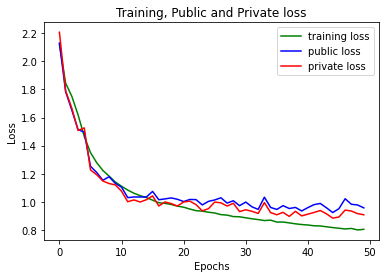

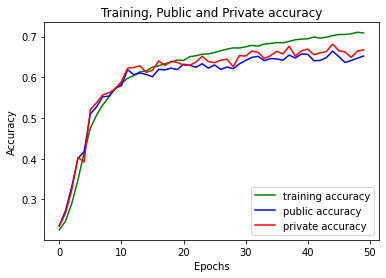

In [ ]:
'''Train Fer2013 with PyTorch.'''
# 10 crop for data enhancement
from __future__ import print_function
from statistics import variance

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import numpy as np
import os
import argparse
from torch.autograd import Variable
import matplotlib.pyplot as plt

bs = 16
lr = 0.01
dataset = 'FER2013'
model = 'VGG19'

use_cuda = torch.cuda.is_available()
best_public = 0     # best public test accuracy
best_public_epoch = 0
best_private = 0    # best private test accuracy
best_private_epoch = 0
start_epoch = 0



learning_rate_decay_start = 80
learning_rate_decay_every = 5
learning_rate_decay_rate = 0.9

cut_size = 44
total_epoch = 50

arr_train_loss = []
arr_public_loss = []
arr_private_loss = []

arr_train_acc = []
arr_public_acc = []
arr_private_acc = []

path = os.path.join('/content/drive/MyDrive/FER_data')

# Data
print("==> Preparing data...")
transform_train = Compose([
    RandomCrop(44),
    RandomHorizontalFlip(),
    ToTensor(),
])

transform_test = Compose([
    TenCrop(cut_size),
    Lambda(lambda crops: torch.stack([ToTensor()(crop) for crop in crops])),
])

trainset = FER2013(split='Training', transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers = 0)
PublicTestset = FER2013(split = 'PublicTest', transform=transform_test)
PublicTestloader = torch.utils.data.DataLoader(PublicTestset, batch_size=bs, shuffle=False, num_workers=0)
PrivateTestset = FER2013(split = 'PrivateTest', transform=transform_test)
PrivateTestloader = torch.utils.data.DataLoader(PrivateTestset, batch_size=bs, shuffle=False, num_workers=0)

# model
net = VGG('VGG16')


print("==> building model...")
    
if(use_cuda):
    net.cuda()
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)


#training
def train(epoch):
    print("\n Epoch: %d" % epoch)
    global Train_acc
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    
    if epoch > learning_rate_decay_start and learning_rate_decay_start >= 0:
        frac = (epoch - learning_rate_decay_start) // learning_rate_decay_every
        decay_factor = learning_rate_decay_rate ** frac
        current_lr = lr * decay_factor
        set_lr(optimizer, current_lr)     # set the decayed rate
    else:
        current_lr = lr
        
    print("Learning rate: %s" % str(current_lr))
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
            
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        clip_gradient(optimizer, 0.1)
        optimizer.step()
        train_loss += loss.data.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        
        progress_bar(batch_idx, len(trainloader), "Loss: %.3f | Acc: %.3f%% (%d%d)" %(train_loss / (batch_idx + 1), 100. * correct/total, correct, total))
        
    Train_acc = 100.*correct/total
    arr_train_loss.append(train_loss/ (batch_idx + 1))
    arr_train_acc.append(correct/total)
    print('Loss: %.3f' % (train_loss / (batch_idx + 1)))

    
def PublicTest(epoch):
    global PublicTest_acc
    global best_public
    global best_public_epoch
    net.eval()
    PublicTest_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(PublicTestloader):
        bs, ncrops, c, h, w = np.shape(inputs)
        inputs = inputs.view(-1, c, h, w)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile = True), Variable(targets)
        outputs = net(inputs)
        outputs_avg = outputs.view(bs, ncrops, -1).mean(1)
        loss = criterion(outputs_avg, targets)
        PublicTest_loss += loss.data.item()
        _, predicted = torch.max(outputs_avg.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        progress_bar(batch_idx, len(PublicTestloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                           % (PublicTest_loss / (batch_idx + 1), 100. * correct / total, correct, total))
        
    print('Loss: %.3f' % (PublicTest_loss / (batch_idx + 1)))

    
    arr_public_loss.append(PublicTest_loss / (batch_idx + 1))

    # Save checkpoint
    PublicTest_acc = 100.*correct/total
    arr_public_acc.append(correct/total)
    if PublicTest_acc >= best_public:
        print('Saving...')
        print("Best public test accuracy: %0.3f" % PublicTest_acc)
        state = {
            'net': net.state_dict() if use_cuda else net(),
            'acc': PublicTest_acc,
            'epoch': epoch,
        }
        
        if not os.path.isdir(path):
            os.mkdir(path)
        torch.save(state, os.path.join(path, 'PublicTest_model.t7'))
        best_public = PublicTest_acc
        best_public_epoch = epoch


def PrivateTest(epoch):
    global PrivateTest_acc
    global best_private
    global best_private_epoch
    net.eval()
    PrivateTest_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(PrivateTestloader):
        bs, ncrops, c, h, w = np.shape(inputs)
        inputs = inputs.view(-1, c, h, w)
        
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        
        inputs, targets = Variable(inputs, volatile = True), Variable(targets)
        outputs = net(inputs)
        outputs_avg = outputs.view(bs, ncrops, -1).mean(1)
        loss = criterion(outputs_avg, targets)
        
        PrivateTest_loss += loss.data.item()
        _, predicted = torch.max(outputs_avg.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        
        progress_bar(batch_idx, len(PublicTestloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (PrivateTest_loss / (batch_idx + 1), 100. * correct / total, correct, total))
        
    print('Loss: %.3f' % (PrivateTest_loss / (batch_idx + 1)))
    
    arr_private_loss.append(PrivateTest_loss / (batch_idx + 1))

    # save checkpoint
    PrivateTest_acc = 100.*correct/total
    arr_private_acc.append(correct/total)
    if PrivateTest_acc >= best_private:
        print("Saving...")
        print("Best private test accuracy: %0.3f" % PrivateTest_acc)
        state = {
            'net': net.state_dict() if use_cuda else net,
            'best_public': best_public,
            'best_private': PrivateTest_acc,
            'best_public_epoch': best_public_epoch,
            'best_private_epoch': best_private_epoch,
        }
        
        if not os.path.isdir(path):
            os.mkdir(path)
            
        torch.save(state, os.path.join(path, 'PrivateTest_model.t7'))
        best_private = PrivateTest_acc
        best_private_epoch = epoch
        
        
for epoch in range(start_epoch, total_epoch):
    train(epoch)
    PublicTest(epoch)
    PrivateTest(epoch)
    
print("Best public test accuracy: %0.3f" % best_public)
print("Best public test epoch: %d" % best_public_epoch)
print("Best private test accuracy: %0.3f" % best_private)
print("Best private test epoch: %d" % best_private_epoch)


epoch = range(start_epoch,total_epoch)
plt.plot(epoch, arr_train_loss, 'g', label='training loss')
plt.plot(epoch, arr_public_loss, 'b', label='public loss')
plt.plot(epoch, arr_private_loss, 'r', label='private loss')
plt.title('Training, Public and Private loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/FER_data/loss.png')
plt.show()

plt.plot(epoch, arr_train_acc, 'g', label='training accuracy')
plt.plot(epoch, arr_public_acc, 'b', label='public accuracy')
plt.plot(epoch, arr_private_acc, 'r', label='private accuracy')
plt.title('Training, Public and Private accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/FER_data/accuracy.png')
plt.show()
